In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests

## Воспроизведение проблемы с расчетом доверительного интервала после применения bootstrap

In [41]:
#Загружаем данные
logins = pd.read_csv('data/logins.csv')
payments = pd.read_csv('data/payments.csv')

In [42]:
# Привести все таймстампы к дейт тайму
logins['datetime'] = pd.to_datetime(logins['timestamp'], unit='s')
payments['datetime'] = pd.to_datetime(payments['timestamp'], unit='s')

# Выделяем дату из дейттайма
logins['date'] = logins['datetime'].dt.date
payments['date'] = payments['datetime'].dt.date

In [111]:
# К данным о логинах добавляем данные о платежах,
unique_logins = logins.drop_duplicates(subset='user_id')

unique_logins_payments = unique_logins.merge(
    payments[['user_id', 'datetime', 'payment_tag', 'price']],
    how='left',
    on='user_id',
)

unique_logins_payments.fillna({'price':0.0}, inplace=True)
unique_logins_payments.groupby('group').price.sum()
unique_logins_payments

,timestamp,user_id,group,datetime_x,date,datetime_y,payment_tag,price
0,1116547257,300647965937,2,2005-05-20 00:00:57,2005-05-20,NaT,NaN,0.0
1,1116547342,300647965938,2,2005-05-20 00:02:22,2005-05-20,NaT,NaN,0.0
2,1116547342,300647965942,1,2005-05-20 00:02:22,2005-05-20,NaT,NaN,0.0
3,1116547567,300647965950,2,2005-05-20 00:06:07,2005-05-20,NaT,NaN,0.0
4,1116547730,300647965957,3,2005-05-20 00:08:50,2005-05-20,NaT,NaN,0.0
...,...,...,...,...,...,...,...,...
124891,1123957167,304942760556,2,2005-08-13 18:19:27,2005-08-13,NaT,NaN,0.0
124892,1124110876,304942750846,1,2005-08-15 13:01:16,2005-08-15,NaT,NaN,0.0
124893,1124194712,304942759552,1,2005-08-16 12:18:32,2005-08-16,NaT,NaN,0.0
124894,1124319998,304942766740,1,2005-08-17 23:06:38,2005-08-17,NaT,NaN,0.0


In [75]:
# Разделим данные на группы
control = unique_logins_payments[unique_logins_payments['group'] == 1]
group2 = unique_logins_payments[unique_logins_payments['group'] == 2]
group3 = unique_logins_payments[unique_logins_payments['group'] == 3]

In [187]:
# Используем bootstrap для создания распределений ARPU

boot_1= []
for i in range(1000):
    boot_sample = control.sample(frac = 1.0, replace = True)
    boot_arpu = sum(boot_sample.price)/boot_sample.user_id.nunique()
    boot_1.append(boot_arpu)
boot_1 = pd.DataFrame(boot_1)

boot_2= []
for i in range(1000):
    boot_sample = group2.sample(frac = 1.0, replace = True)
    boot_arpu = sum(boot_sample.price)/boot_sample.user_id.nunique()
    boot_2.append(boot_arpu)
boot_2 = pd.DataFrame(boot_2)

boot_3= []
for i in range(1000):
    boot_sample = group3.sample(frac = 1.0, replace = True)
    boot_arpu = sum(boot_sample.price)/boot_sample.user_id.nunique()
    boot_3.append(boot_arpu)

boot_3 = pd.DataFrame(boot_3)


In [188]:
# Рассчитаем разницы распределений ARPU попарно
boot1_2 = boot_1-boot_2
boot1_3 = boot_1-boot_3
boot2_3 = boot_2-boot_3

,0
0,-0.377460
1,-0.566472
2,-0.118069
3,-0.239714
4,-0.050458
...,...
995,-0.191387
996,-0.355319
997,-0.089364
998,-0.414968


c:\users\ivnat\projects\scorewarriors_test\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\ivnat\projects\scorewarriors_test\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\ivnat\projects\scorewarriors_test\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

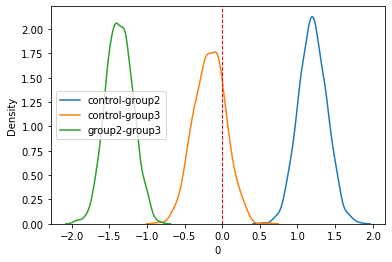

In [189]:
# Визуализируем разницу
fig, ax = plt.subplots()
sns.distplot(boot1_2[0], hist=False)
sns.distplot(boot1_3[0], hist=False)
sns.distplot(boot2_3[0], hist=False)
plt.axvline( x=0.0, color='r', linestyle='dashed', linewidth=1, label=f'mean')
ax.legend(['control-group2', 'control-group3', 'group2-group3'])
plt.show()


In [196]:
# Проводим одновыборочный t-test с нулем
from scipy import stats
t, p = stats.ttest_1samp(boot1_3[0], popmean=0)
t,p

# p-value практически равен нулю

(-24.912781754285966, 6.125872659388898e-107)

In [197]:
from statsmodels.stats.weightstats import ztest
ztest(boot1_3[0], alternative='two-sided', usevar='pooled')
# Та же ситуация с z-тестом

(-24.912781754285966, 5.408832364390017e-137)

In [198]:
# Построим доверительный интервал
import numpy as np, scipy.stats as st

print(
    f'Min {boot1_3[0].min()} \n'
    f'Mean {boot1_3[0].mean()} \n'
    f'Max {boot1_3[0].max()}'

)
ci = st.t.interval(0.99, len(boot1_3[0])-1, loc=np.mean(boot1_3[0]), scale=st.sem(boot1_3[0]))
ci

# Доверительный интервал получается очень узким, практически как среднее значение

Min -0.8481230477155961 
Mean -0.164639769564099 
Max 0.5876765564118642


(-0.18169509787591917, -0.14758444125227885)

In [199]:
from stat_funcs import statistical_normality_test

statistical_normality_test(feature_name=0, df_name=boot1_3, alpha=0.05)


0 normality check 

Shapiro-Wilk normality test for 0
Statistics=0.9986, p-value=0.6202% 

Shapiro-Wilk: Sample looks Gaussian (fail to reject H0) 

D’Agostino’s K^2 normality Test test for 0
Statistics=0.9745, p-value=0.6143% 

D’Agostino’s: Sample looks Gaussian (fail to reject H0) 



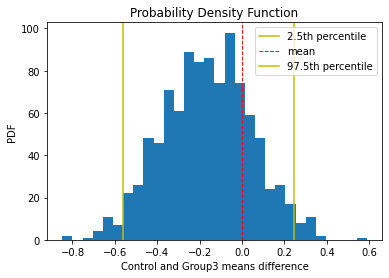

In [200]:
# Plot the PDF for bootstrap replicates as histogram
plt.hist(boot1_3,bins=30)

# Showing the related percentiles
plt.axvline(x=np.percentile(boot1_3,[2.5]), ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline( x=0.0, color='r', linestyle='dashed', linewidth=1, label=f'mean')
plt.axvline(x=np.percentile(boot1_3,[97.5]), ymin=0, ymax=1,label='97.5th percentile',c='y')

plt.xlabel("Control and Group3 means difference")
plt.ylabel("PDF")
plt.title("Probability Density Function")
plt.legend()
plt.show()

# Но при расчете доверительного интервала с помощью np.percentile дает корректный результат

In [201]:
# Get the corresponding values of 2.5th and 97.5th percentiles
conf_interval = np.percentile(boot1_3,[2.5,97.5])

# Print the interval
print("The confidence interval: ",conf_interval)




The confidence interval:  [-0.56088956  0.24680559]
